## Setup

In [ ]:
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from focal_loss import SparseCategoricalFocalLoss
from sklearn.metrics import classification_report

## Load CSV Data

In [572]:
train = pd.read_csv('/Users/munibasiddiqi/Desktop/BUCS767/Homework_Assignments/Project/diabetic_retinopathy_dataset/aptos2019-blindness-detection/train.csv')
#test = pd.read_csv('/Users/munibasiddiqi/Desktop/BUCS767/Homework_Assignments/Project/diabetic_retinopathy_dataset/aptos2019-blindness-detection/test.csv')  # does not have labels

print('Number of train samples: ', train.shape[0])
#print('Number of test samples: ', test.shape[0])
print(train.head())

Number of train samples:  3662
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


### Class distribution in train data

In [369]:
class_0 = train[train['diagnosis'] == 0]
class_1 = train[train['diagnosis'] == 1]
class_2 = train[train['diagnosis'] == 2]
class_3 = train[train['diagnosis'] == 3]
class_4 = train[train['diagnosis'] == 4]
print("Number of sample of class 0 =", class_0.count()[0])
print("Number of sample of class 1 =", class_1.count()[0])
print("Number of sample of class 2 =", class_2.count()[0])
print("Number of sample of class 3 =", class_3.count()[0])
print("Number of sample of class 4 =", class_4.count()[0])

Number of sample of class 0 = 1805
Number of sample of class 1 = 370
Number of sample of class 2 = 999
Number of sample of class 3 = 193
Number of sample of class 4 = 295


### Plot

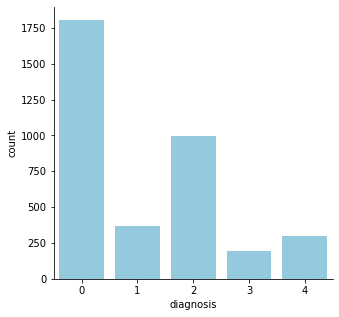

In [370]:
f, ax = plt.subplots(figsize=(5,5))
ax = sns.countplot(x="diagnosis", data=train, color='skyblue')
sns.despine()
plt.show()

### Preprocess csv data

In [371]:
train['id_code'] = train['id_code'].apply(lambda x:x+".png")
train['diagnosis'] = train['diagnosis'].astype('str')
#test['id_code'] = test['id_code'].apply(lambda x:x+".png")
train.head()
#test.head()


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [372]:
class_0 = train[train['diagnosis'] == '0']
class_1 = train[train['diagnosis'] == '1']
class_2 = train[train['diagnosis'] == '2']
class_3 = train[train['diagnosis'] == '3']
class_4 = train[train['diagnosis'] == '4']
class_0.head()

,id_code,diagnosis
3,002c21358ce6.png,0
4,005b95c28852.png,0
6,0097f532ac9f.png,0
10,00cc2b75cddd.png,0
12,00f6c1be5a33.png,0


In [373]:
print("Number of sample of class 0 =", class_0.count()[0])
print("Number of sample of class 1 =", class_1.count()[0])
print("Number of sample of class 2 =", class_2.count()[0])
print("Number of sample of class 3 =", class_3.count()[0])
print("Number of sample of class 4 =", class_4.count()[0])

Number of sample of class 0 = 1805
Number of sample of class 1 = 370
Number of sample of class 2 = 999
Number of sample of class 3 = 193
Number of sample of class 4 = 295


## Visualize Eye Images

### The dataset contains five sub-directories, one per class:
#### train_images/
  class_0/

  class_1/

  class_2/

  class_3/
  
  class_4/

### Data directory path

In [375]:
import pathlib
data_dir = "/Users/munibasiddiqi/Desktop/BUCS767/Homework_Assignments/Project/diabetic_retinopathy_dataset/aptos2019-blindness-detection/train_images/"
data_dir = pathlib.Path(data_dir)
print(data_dir)


/Users/munibasiddiqi/Desktop/BUCS767/Homework_Assignments/Project/diabetic_retinopathy_dataset/aptos2019-blindness-detection/train_images


In [376]:
image_count = len(list(data_dir.glob('*/*.png')))
print("Total count of images in APTOS2019 dataset = ", image_count)

Total count of images in APTOS2019 dataset =  3662


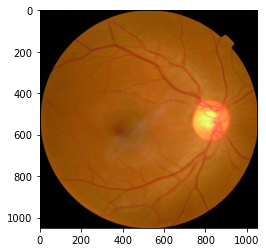

In [577]:
path = list(data_dir.glob('class_0/*'))
img = tf.keras.preprocessing.image.load_img(str(path[0]))
img = tf.keras.preprocessing.image.img_to_array(img)
plt.imshow(img/255)



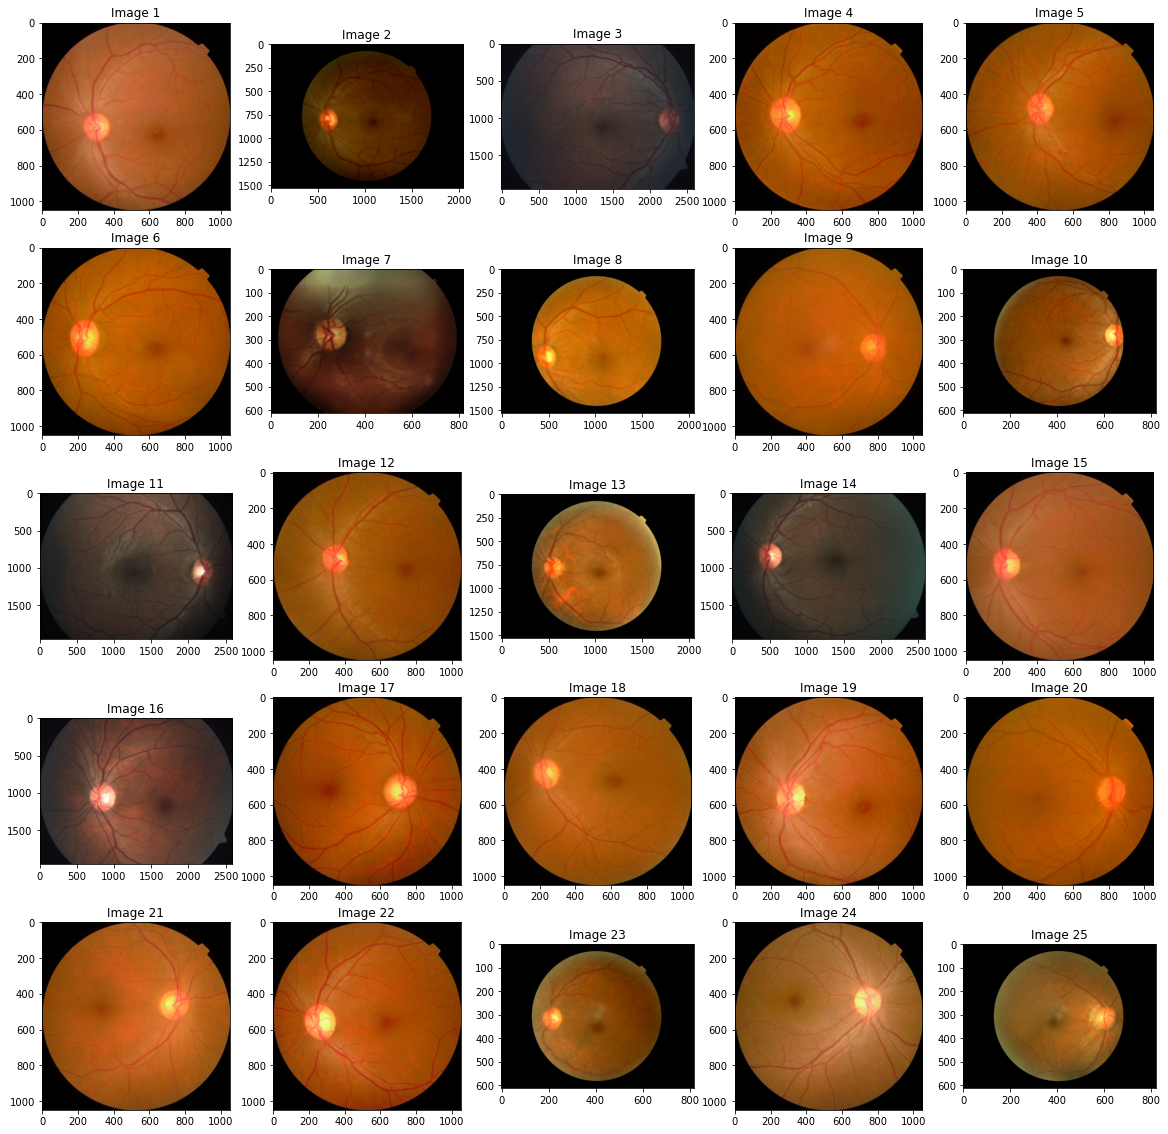

In [578]:
count = 1
plt.figure(figsize=[20, 20])
for img_name in class_0['id_code'][:25]:
    #img = cv2.imread("/Users/munibasiddiqi/Desktop/BUCS767/Homework_Assignments/Project/diabetic_retinopathy_dataset/aptos2019-blindness-detection/train_images/class_0/%s" % img_name)[...,[2, 1, 0]]
    #img = tf.keras.preprocessing.image.load_img("/Users/munibasiddiqi/Desktop/BUCS767/Homework_Assignments/Project/diabetic_retinopathy_dataset/aptos2019-blindness-detection/train_images/class_0/%s" % img_name, target_size=(224, 224))
    img = tf.keras.preprocessing.image.load_img("/Users/munibasiddiqi/Desktop/BUCS767/Homework_Assignments/Project/diabetic_retinopathy_dataset/aptos2019-blindness-detection/train_images/class_0/%s" % img_name)
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

## Load data using a Keras utility
This will load images from a directory on disk to a tf.data.Dataset

### Model parameters
Standardizing image size (224 x 224)

In [378]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (224, 224)

### Train set

In [509]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  class_names=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'],
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 3662 files belonging to 5 classes.
Using 2747 files for training.


### Validation set

In [536]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  class_names=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'],
  validation_split=0.25,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 3662 files belonging to 5 classes.
Using 915 files for validation.


### Class_names

In [514]:
class_names = train_dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
5


### Visualize train data

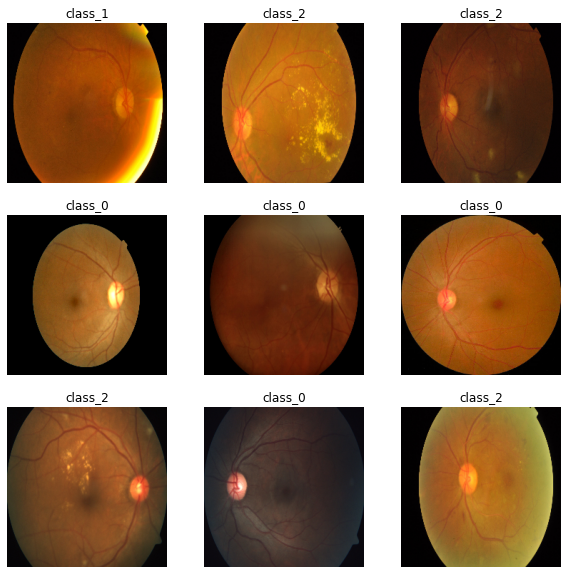

In [383]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [384]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [385]:
for image, label in train_dataset.take(1):
    print(image.numpy())
    print(label.numpy())

[[[[6.370416  5.629584  6.7408323]
   [5.339287  5.339287  5.598215 ]
   [5.9699464 5.9699464 7.202086 ]
   ...
   [6.5861206 5.3536987 5.9699097]
   [5.9597864 4.299142  7.129464 ]
   [6.        6.        8.       ]]

  [[5.726961  5.726961  7.726961 ]
   [5.595903  5.595903  7.595903 ]
   [6.466954  6.466954  8.466954 ]
   ...
   [5.7652717 5.52594   8.243935 ]
   [5.4921684 4.9843373 8.507832 ]
   [6.        5.8308225 8.338355 ]]

  [[6.        5.9023833 8.195233 ]
   [5.695514  5.695514  7.695514 ]
   [5.5341988 5.5341988 7.0371475]
   ...
   [5.782675  6.        8.       ]
   [5.64732   6.        8.       ]
   [4.4341807 4.613237  6.613237 ]]

  ...

  [[6.2550497 5.647339  8.705322 ]
   [6.5821314 5.8303566 6.7090087]
   [5.113136  5.2172637 8.233657 ]
   ...
   [5.4346275 5.        6.5119915]
   [4.3776608 5.940161  7.7875   ]
   [5.526261  5.        7.905884 ]]

  [[6.        5.723214  8.553572 ]
   [6.        6.        5.660713 ]
   [4.        5.623229  5.7535424]
   ...
   [6

In [386]:
for images, labels in train_dataset.take(1):
    print(images[0].numpy())
    print(labels[0].numpy())

[[[3.9641662 3.0936303 7.705238 ]
  [4.3626833 5.2551823 7.2551823]
  [4.        3.        8.       ]
  ...
  [4.0797772 3.2844152 7.282109 ]
  [4.        4.        6.       ]
  [4.629736  4.9063473 6.9063473]]

 [[4.        4.        6.       ]
  [4.1696434 3.8303566 5.7924895]
  [3.223215  6.239277  4.521446 ]
  ...
  [3.3883924 4.2347283 5.5305433]
  [4.0659018 4.0659018 6.0659018]
  [4.        4.        6.       ]]

 [[4.        4.        6.       ]
  [4.229473  3.597336  6.76519  ]
  [4.7514744 5.        7.       ]
  ...
  [3.8646452 3.8646452 5.864645 ]
  [4.        4.        6.       ]
  [4.4682636 4.4682636 6.4682636]]

 ...

 [[5.103299  4.9023886 7.8844967]
  [5.4624777 3.8017647 7.098137 ]
  [4.5193276 3.1666663 8.166666 ]
  ...
  [4.398897  4.398897  5.601103 ]
  [4.059839  4.5875    6.7670164]
  [4.        4.        6.       ]]

 [[4.450191  4.8924885 6.330656 ]
  [4.        4.354933  8.677466 ]
  [4.61607   4.61607   6.61607  ]
  ...
  [3.5259318 3.5259318 1.9953613]
  [4

# Test Data
As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [542]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [538]:
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_dataset))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_dataset2))

Number of training samples: 86
Number of validation samples: 24
Number of test samples: 5


## Configure the dataset for performance


In [543]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. I will use data augmentation and add Dropout to my model.

In [390]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT, IMG_WIDTH,3)),
    layers.RandomRotation(0.2, fill_mode = 'constant'),
    layers.RandomZoom(0.1, fill_mode = 'constant')
  ]
)


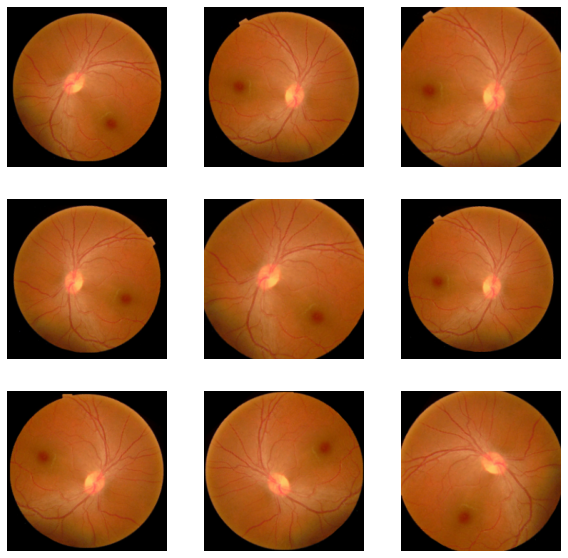

In [391]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images,training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout regularization
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

## Preprocess input for Resnet50 

In [392]:
# The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Tranfer Learning using ResNet50
### Create the base model from the pre-trained convnets

In [398]:
# Instantiate a base model
base_model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False # Do not include the ImageNet classifier at the top
)  

# Freeze the base_model
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Build a model

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. Use training=False as our model contains a BatchNormalization layer (Pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.).

In [399]:
# Create a model
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)  # apply random data augmentation
x = preprocess_input(x)  # The images are converted from RGB to BGR required by ResNet50 then each color channel is zero-centered with respect to the ImageNet dataset, without scaling
x = base_model(x, training=False)   # add a pre-trained base model to utilize transfer learning (ResNet50)
x = keras.layers.GlobalAveragePooling2D()(x)    # add a pooling layer to downsample feature maps
x = keras.layers.Dropout(0.5)(x)  # regularize with dropout
x = keras.layers.Dense(2048, activation='relu')(x)  # add a fully-connected layer
outputs = keras.layers.Dense(5, activation='softmax')(x) #  add a logistic layer -- we have 5 classes
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

## Compile the model 
### Learning_rate = 0.001
### Loss function = multi-class focal loss
### Optimizer = Adam


In [400]:
# Compile the model
from focal_loss import SparseCategoricalFocalLoss
base_learning_rate = 0.001 # default

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = base_learning_rate),
    loss=SparseCategoricalFocalLoss(gamma=2,from_logits=False), # multiclass cross-entropy loss that penalizes hard-to-classify examples
              metrics=['accuracy']
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

In [401]:
# Number of trainable variables
len(model.trainable_variables)

4

## LR Finder

In [43]:
class LRFind(tf.keras.callbacks.Callback): 
    def __init__(self, min_lr, max_lr, n_rounds): 
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_up = (max_lr / min_lr) ** (1 / n_rounds)
        self.lrs = []
        self.losses = []
     
    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.model.optimizer.lr = self.min_lr

    def on_train_batch_end(self, batch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())
        self.losses.append(logs["loss"])
        self.model.optimizer.lr = self.model.optimizer.lr * self.step_up
        if self.model.optimizer.lr > self.max_lr:
            self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)

85/85 [==============================] - 179s 2s/step - loss: 3.5408 - accuracy: 0.5191


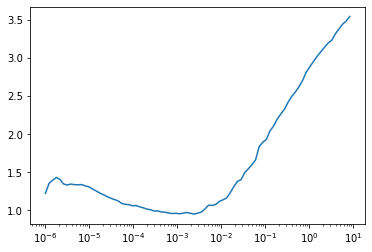

In [44]:
EPOCHS = 1
BATCH_SIZE = 32
lr_finder_steps = 85
lr_find = LRFind(1e-6, 1e1, lr_finder_steps)

model.fit(
    train_dataset,
    steps_per_epoch=lr_finder_steps,
    epochs=EPOCHS,
    callbacks=[lr_find]
)

plt.plot(lr_find.lrs, lr_find.losses)
plt.xscale('log')
plt.show()

#### This plot shows that loss is minimum at learning rate 1e-3 (0.001)

#### This feature extractor converts each 224x224x3 image into a 7x7x2048 block of features. Let's see what it does to an example batch of images:

In [402]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [403]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [404]:
dense_layer = tf.keras.layers.Dense(2048, activation='relu')
dense_batch = dense_layer(feature_batch_average)
print(dense_batch.shape)

(32, 2048)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.




In [405]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(dense_batch)
print(prediction_batch.shape)

(32, 5)


## Train the model

In [406]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

24/24 [==============================] - 55s 2s/step - loss: 1.2346 - accuracy: 0.1166
initial loss: 1.23
initial accuracy: 0.12
Epoch 1/20
86/86 [==============================] - 242s 3s/step - loss: 1.5398 - accuracy: 0.6473 - val_loss: 1.2357 - val_accuracy: 0.6411
Epoch 2/20
86/86 [==============================] - 242s 3s/step - loss: 0.6108 - accuracy: 0.7306 - val_loss: 0.3489 - val_accuracy: 0.7550
Epoch 3/20
86/86 [==============================] - 235s 3s/step - loss: 0.3817 - accuracy: 0.7317 - val_loss: 0.3202 - val_accuracy: 0.7576
Epoch 4/20
86/86 [==============================] - 229s 3s/step - loss: 0.3447 - accuracy: 0.7444 - val_loss: 0.3194 - val_accuracy: 0.7642
Epoch 5/20
86/86 [==============================] - 230s 3s/step - loss: 0.3347 - accuracy: 0.7481 - val_loss: 0.3127 - val_accuracy: 0.7550
Epoch 6/20
86/86 [==============================] - 228s 3s/step - loss: 0.3193 - accuracy: 0.7583 - val_loss: 0.2869 - val_accuracy: 0.7828
Epoch 7/20
86/86 [=======

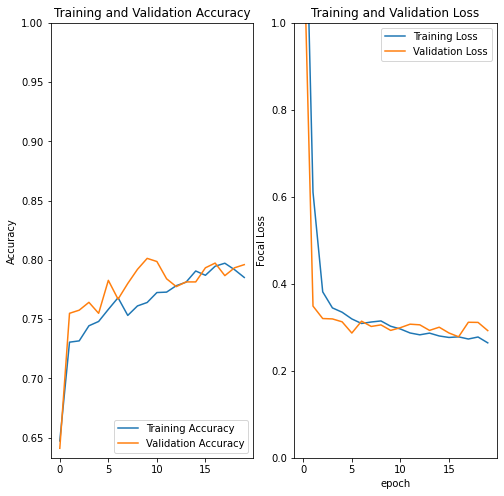

In [407]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Focal Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In the plots above, the training accuracy and validation accuracy stalls around 80% in the training process. 

In [408]:
loss, accuracy = model.evaluate(validation_dataset)

24/24 [==============================] - 53s 2s/step - loss: 0.2851 - accuracy: 0.7960


## Save model

In [409]:
model.save("./my_model")

INFO:tensorflow:Assets written to: ./my_model_focalLoss_2048_05/assets


INFO:tensorflow:Assets written to: ./my_model_focalLoss_2048_05/assets


## Reload a fresh Keras model from the saved model:

In [ ]:
# Reload a fresh Keras model from the saved model:
model = tf.keras.models.load_model("./my_model")

# Check its architecture
model.summary()

## Additional Training

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

additional_epochs = 10
total_epochs =  initial_epochs + additional_epochs

history = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


## Evaluation and prediction

In [410]:
# Evaluate the model on the test data 
print("Evaluate on test data")
loss, accuracy = model.evaluate(test_dataset)
print("test loss: {:5.2f}%".format(100 *loss))
print("test acc: {:5.2f}%".format(100 * accuracy))

Evaluate on test data
5/5 [==============================] - 14s 2s/step - loss: 0.3367 - accuracy: 0.7688
test loss: 33.67%
test acc: 76.88%


In [494]:
# Generate predictions (probabilities -- the output of the last layer)
print("Generate predictions for test samples")
predictions = model.predict(test_dataset)
print("predictions shape:", predictions.shape)

Generate predictions for test samples
5/5 [==============================] - 14s 2s/step
predictions shape: (160, 5)


In [412]:
predictions[:5]

array([[7.1755081e-02, 3.7514234e-01, 4.6008953e-01, 1.5369436e-02,
        7.7643618e-02],
       [3.9622979e-03, 4.5175619e-02, 7.1044117e-01, 5.3219009e-02,
        1.8720193e-01],
       [9.1805375e-01, 6.3625738e-02, 1.7310562e-02, 1.4476450e-04,
        8.6523750e-04],
       [9.5697820e-01, 2.3071742e-02, 1.8818704e-02, 6.6712656e-04,
        4.6421043e-04],
       [8.3594978e-01, 7.9124287e-02, 8.0136918e-02, 1.8127756e-04,
        4.6077385e-03]], dtype=float32)

In [495]:
test_predictions = [np.argmax(pred) for pred in predictions]

In [496]:
test_predictions[:10]

[2, 0, 4, 2, 0, 0, 2, 3, 0, 0]

In [497]:
y_predicted =  [tf.argmax(pred) for pred in predictions]
y_predicted[:10]

[<tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>]

### Extract labels for test dataset

In [544]:
test_labels = np.concatenate([label for image, label in test_dataset], axis=0)
test_labels

array([1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 4, 0, 2, 0, 2, 2, 0, 0, 3, 4, 4,
       0, 0, 1, 0, 3, 2, 2, 4, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1,
       1, 2, 0, 4, 2, 2, 0, 4, 2, 0, 2, 0, 2, 0, 0, 4, 1, 4, 2, 1, 1, 0,
       0, 2, 4, 0, 0, 2, 2, 2, 4, 2, 3, 0, 2, 2, 0, 2, 4, 0, 2, 2, 0, 2,
       1, 1, 2, 1, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 3, 0, 0,
       4, 2, 0, 2, 0, 0, 4, 3, 4, 2, 0, 2, 2, 3, 0, 0, 0, 0], dtype=int32)

### Confusion Matrix
The matrix columns represent the prediction labels and the rows represent the real labels.

In [502]:
# Confusion matrix
conf_matrix = tf.math.confusion_matrix(labels=test_labels,
                                       predictions=test_predictions)
conf_matrix

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[45,  4, 28,  3,  1],
       [ 6,  3, 11,  1,  0],
       [24,  1, 14,  0,  0],
       [ 3,  0,  5,  1,  0],
       [ 4,  0,  5,  0,  1]], dtype=int32)>

In [504]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              cmap='Blues', annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('True Label')
  plt.xticks(rotation=90)
  plt.title('Confusion Matrix', fontsize=20)
  plt.show()

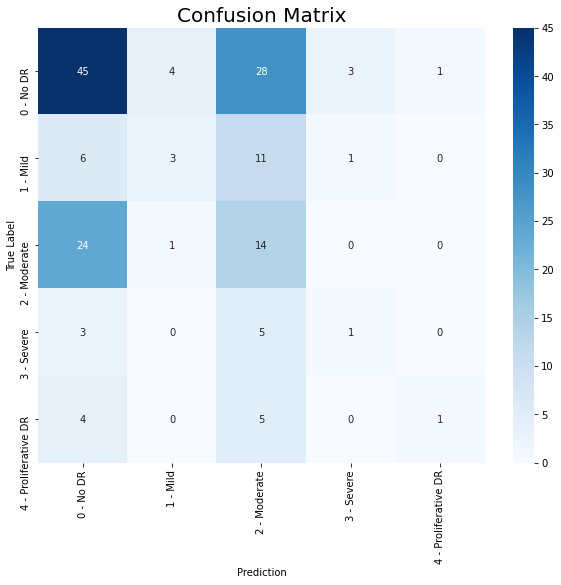

                      precision    recall  f1-score   support

           0 - No DR       0.55      0.56      0.55        81
            1 - Mild       0.38      0.14      0.21        21
        2 - Moderate       0.22      0.36      0.27        39
          3 - Severe       0.20      0.11      0.14         9
4 - Proliferative DR       0.50      0.10      0.17        10

            accuracy                           0.40       160
           macro avg       0.37      0.25      0.27       160
        weighted avg       0.42      0.40      0.39       160



In [505]:
# Confusion matrix
conf_matrix = tf.math.confusion_matrix(labels=test_labels,
                                       predictions=test_predictions)

# Class labels
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Plot confusion matrix
show_confusion_matrix(conf_matrix, labels)

# Report
print(classification_report(test_labels, test_predictions, target_names=labels))